# Prototyping

Creates a neural network which evaluates a time series and produce a set of predicted values for the time series
Predicted values may be used in a policy to make a trade. This policy may be modeled by simple multiple regression or a neural network.

## Data
Test data is taken as most recent to avoid lookahead bias. Train data is split into a validation and training set during fitting.


## TODO
- Adding VIX as a signal
- Adding High/Low as signals
- Multiple securities/ aggregate samples
- Policy network
- Regularization (l2)
- Dilated convolution

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import pandas_datareader as pdr
from datetime import datetime
from scipy import stats


NUM_INPUT_NEURONS = 64
NUM_OUTPUT_NEURONS = 1
DAY_OFFSET = 5

def from_network(symbol):
    return pdr.get_data_yahoo(symbols=symbol, start=datetime(1900, 1, 1)).sort_values(by=['Date'],ascending=False)

# Create features (only close price for now)
def convert_to_percentage(old, new):
    return round((old - new) / old, 3)

def convert_labels_to_category(labels): 
    # Simplification - If positive return, 1, else 0
#     return map(lambda arr: [2] if arr[0] > 1 else [0], labels)
    # rounding simpliciation
    return map(lambda arr: map(lambda val: round(val,5),arr), labels)


def convert_to_train(raw_vix_dataset, raw_benchmark_dataset, raw_dataset, offset=5):
    vix_dataset = raw_vix_dataset.copy()
    benchmark_dataset = raw_benchmark_dataset.copy()
    dataset = raw_dataset.copy()
    features = []
    labels = []
    for i in range(offset, len(dataset) - NUM_INPUT_NEURONS):

        vix_feature_dataset = vix_dataset[i:i+NUM_INPUT_NEURONS].copy()
        beta_feature_dataset = benchmark_dataset[i:i+NUM_INPUT_NEURONS].copy()
        feature_dataset = dataset[i:i+NUM_INPUT_NEURONS].copy()
        
        vix_latest_close = vix_feature_dataset['Close'].iloc[0]
        beta_latest_close = beta_feature_dataset['Close'].iloc[0]
        latest_close = feature_dataset['Close'].iloc[0]
        
        vix_close_features = vix_feature_dataset['Close'].map(lambda current: convert_to_percentage(vix_latest_close, current)).tolist()
        beta_close_features = beta_feature_dataset['Close'].map(lambda current: convert_to_percentage(beta_latest_close, current)).tolist()
        close_features = feature_dataset['Close'].map(lambda current: convert_to_percentage(latest_close, current)).tolist()

#         open_features = feature_dataset['Open'].map(lambda current: convert_to_percentage(latest_close, current)).tolist()
        features.append(
            zip(
                vix_close_features,
                beta_close_features,
                close_features,
#                 open_features,
            )
        )
        labels.append([
            dataset['Close'].iloc[i-DAY_OFFSET] / latest_close, # 1 day trade
#             dataset['High'].iloc[i-1] / latest_close, # 1 day trade
#             dataset['Low'].iloc[i-1] / latest_close, # 1 day trade
            
#             dataset['Close'].iloc[i-3] / latest_close, # 3 day trade
#             dataset['High'].iloc[i-3] / latest_close, # 1 day trade
#             dataset['Low'].iloc[i-3] / latest_close, # 1 day trade
            
#             dataset['Close'].iloc[i-5] / latest_close, # 5 day trade
#             dataset['High'].iloc[i-5] / latest_close, # 1 day trade
#             dataset['Low'].iloc[i-5] / latest_close, # 1 day trade
            
        ])
        
    # Without converting labels the precision is hard to determine accuracy. 
    # Rather than crude 0/1, maybe this can be more sophisticated
    labels = convert_labels_to_category(labels)
    
    return [features,labels]

def split_data(symbol):
    VIX = from_network('^VIX')
    SPY = from_network('SPY')
    fetched = from_network(symbol)
    converted = convert_to_train(VIX, SPY, fetched)
    features = converted[0]
    labels = converted[1]
    prediction = [
        features[:5],
        labels[:5],
    ]
    validation = [
        features[5:1000],
        labels[5:1000]
    ]
    training = [
        features[1000:],
        labels[1000:]
    ]
    return {
        'symbol': symbol,
        'prediction': prediction,
        'validation': validation,
        'training': training,
    }

# retrain model and calculate difference - require convergence
def ranking_difference_squared(arr1, arr2):
    return sum(map(lambda element: (arr2.index(element)- arr1.index(element)) ** 2, arr1)) / len(arr1)



In [2]:

# from_network('^VIX')[7000:]
# VIX = from_network('^VIX')

In [3]:

SPY = from_network('SPY')
VIX = from_network('^VIX')


In [4]:

prepped_data = map(split_data, [
    'SPY',
])


In [5]:

for i in range(len(prepped_data)):
    print prepped_data[i]['symbol']
    
def combine_all(accum, prep):
    
    print len(accum['training'][0])
    return {   
        'prediction':[
            accum['prediction'][0] + prep['prediction'][0],
            accum['prediction'][1] + prep['prediction'][1],
        ],
        'validation':[
            accum['validation'][0] + prep['validation'][0],
            accum['validation'][1] + prep['validation'][1],
        ],
        'training':[
            accum['training'][0] + prep['training'][0],
            accum['training'][1] + prep['training'][1],
        ],
    }
combined = reduce(combine_all, prepped_data,{
    'prediction':[[],[]],
    'validation':[[],[]],
    'training':[[],[]],
})


SPY
0


In [6]:

#init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
# len(combined['training'][0])

In [7]:
#len(converted_feature_set[0][0])
print len(combined['training'][0])
train_data = np.array(combined['training'][0])
train_labels = np.array(combined['training'][1])

print len(combined['validation'][0])
test_data = np.array(combined['validation'][0])
test_labels = np.array(combined['validation'][1])

print len(combined['prediction'][0])
prediction_data = np.array(combined['prediction'][0])
prediction_labels = np.array(combined['prediction'][1])


5587
995
5


In [8]:
#print train_data
#print train_labels

In [9]:

def build_model():
  model = keras.Sequential([
    layers.Conv1D(64, kernel_size=(1), strides=(1),
        activation='relu',
        input_shape=(64,3)),
    layers.MaxPooling1D(3),
    layers.Flatten(),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(48, activation=tf.nn.relu),
    layers.Dense(24, activation=tf.nn.relu),
    layers.Dense(12, activation=tf.nn.relu),
#       layers.Dense(12, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
    layers.Dense(NUM_OUTPUT_NEURONS)
  ])

  model.compile(
      loss='mean_squared_logarithmic_error',
#       loss='mean_squared_error',
#      loss='logcosh',
#       loss='mean_absolute_error',
    optimizer='sgd',
#       optimizer='adam',
#                 metrics=[
#                     'mae',
#                 ]
               )
  return model

tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 64, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 21, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1344)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                86080     
_________________________________________________________________
dense_1 (Dense)              (None, 48)                3120      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                300       
__________

In [10]:
model.fit(
    train_data, train_labels,
    epochs=1, validation_data=(test_data, test_labels), verbose=1,
    callbacks=[tensorboard]
)
history = model.fit(
    train_data, train_labels,
    epochs=50, validation_data=(test_data, test_labels), verbose=1,
    callbacks=[tensorboard]
)

def train_model(model):
    return model.fit(
        train_data, train_labels,
        epochs=100, validation_data=(test_data, test_labels), verbose=1,
        callbacks=[tensorboard]
    )   

# model_1 = build_model()
# model_2 = build_model()
# model_3 = build_model()
# model_4 = build_model()

# map(train_model, [model_1, model_2, model_3, model_4])

Train on 5587 samples, validate on 995 samples
Epoch 1/1
5587/5587 [==============================] - 1s 138us/step - loss: 0.0502 - val_loss: 4.6817e-04
Train on 5587 samples, validate on 995 samples
Epoch 1/50
5587/5587 [==============================] - 1s 92us/step - loss: 4.1213e-04 - val_loss: 3.1934e-04
Epoch 2/50
5587/5587 [==============================] - 1s 97us/step - loss: 3.2644e-04 - val_loss: 2.6192e-04
Epoch 3/50
5587/5587 [==============================] - 1s 96us/step - loss: 2.7523e-04 - val_loss: 2.2985e-04
Epoch 4/50
5587/5587 [==============================] - 1s 91us/step - loss: 2.4206e-04 - val_loss: 2.1493e-04
Epoch 5/50
5587/5587 [==============================] - 1s 91us/step - loss: 2.2024e-04 - val_loss: 2.0687e-04
Epoch 6/50
5587/5587 [==============================] - 1s 94us/step - loss: 2.0633e-04 - val_loss: 2.0125e-04
Epoch 7/50
5587/5587 [==============================] - 1s 90us/step - loss: 1.9663e-04 - val_loss: 1.9988e-04
Epoch 8/50
5587/5587 [

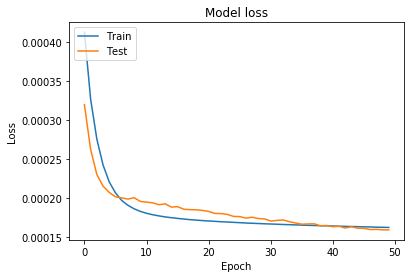

In [11]:
import matplotlib.pyplot as plt


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
outputs = model.predict(test_data)

In [13]:

print stats.describe(test_labels)
print stats.describe(outputs)

DescribeResult(nobs=995, minmax=(array([0.89185]), array([1.06759])), mean=array([1.00186717]), variance=array([0.00034818]), skewness=array([-1.03025953]), kurtosis=array([4.23541071]))
DescribeResult(nobs=995, minmax=(array([0.90291035], dtype=float32), array([1.0534126], dtype=float32)), mean=array([0.99822795], dtype=float32), variance=array([0.0002892], dtype=float32), skewness=array([-1.1715722], dtype=float32), kurtosis=array([3.9597154], dtype=float32))


In [14]:
print outputs[0]
print test_labels[0]
print test_data[0]


[1.0100744]
[0.98526]
[[ 0.     0.     0.   ]
 [ 0.028  0.009  0.009]
 [-0.027  0.012  0.012]
 [-0.041  0.022  0.022]
 [-0.036  0.022  0.022]
 [-0.073  0.021  0.021]
 [-0.079  0.025  0.025]
 [-0.084  0.024  0.024]
 [-0.081  0.023  0.023]
 [-0.105  0.028  0.028]
 [-0.08   0.037  0.037]
 [-0.091  0.044  0.044]
 [-0.151  0.052  0.052]
 [-0.279  0.072  0.072]
 [-0.268  0.07   0.07 ]
 [-0.173  0.057  0.057]
 [-0.214  0.059  0.059]
 [-0.186  0.053  0.053]
 [-0.075  0.044  0.044]
 [-0.147  0.046  0.046]
 [ 0.     0.035  0.035]
 [-0.014  0.032  0.032]
 [-0.106  0.04   0.04 ]
 [-0.082  0.034  0.034]
 [-0.037  0.028  0.028]
 [-0.115  0.037  0.037]
 [-0.224  0.042  0.042]
 [-0.393  0.051  0.051]
 [-0.087  0.026  0.026]
 [-0.295  0.031  0.031]
 [-0.315  0.028  0.028]
 [-0.31   0.027  0.027]
 [-0.047  0.01   0.01 ]
 [ 0.127  0.006  0.006]
 [ 0.022  0.016  0.016]
 [-0.003  0.014  0.014]
 [ 0.111  0.006  0.006]
 [ 0.111  0.007  0.007]
 [ 0.137  0.008  0.008]
 [ 0.102  0.013  0.013]
 [ 0.109  0.012  0

In [15]:
# primitive policy temporarily in place of a RL policy network

# signal step for our policy network
signals = map(lambda arr: sum(arr) / len(arr),outputs)
# signals = map(lambda arr: arr[0],outputs)
trades = map(lambda signal: 1 if round(signal,4) > 1.0 else 0,signals)

In [16]:
zip(signals, outputs)

[(1.0100743770599365, array([1.0100744], dtype=float32)),
 (1.0111134052276611, array([1.0111134], dtype=float32)),
 (0.9943801164627075, array([0.9943801], dtype=float32)),
 (0.9917136430740356, array([0.99171364], dtype=float32)),
 (0.994042158126831, array([0.99404216], dtype=float32)),
 (0.9985755681991577, array([0.99857557], dtype=float32)),
 (1.0061712265014648, array([1.0061712], dtype=float32)),
 (1.0169353485107422, array([1.0169353], dtype=float32)),
 (1.0186641216278076, array([1.0186641], dtype=float32)),
 (1.0136902332305908, array([1.0136902], dtype=float32)),
 (0.9959782361984253, array([0.99597824], dtype=float32)),
 (1.0031434297561646, array([1.0031434], dtype=float32)),
 (1.0049816370010376, array([1.0049816], dtype=float32)),
 (1.0012456178665161, array([1.0012456], dtype=float32)),
 (0.9946993589401245, array([0.99469936], dtype=float32)),
 (0.9956099987030029, array([0.99561], dtype=float32)),
 (1.001070499420166, array([1.0010705], dtype=float32)),
 (0.998800277

In [17]:
# one day return
actual = map(lambda arr: arr[0],test_labels)

df = pd.DataFrame({
    'signal':signals,
    'actual': actual,
    'trade':trades,
})

In [18]:
df['entry_success'] = df.apply (lambda row: 1 if (row['actual'] > 1.00 and row['trade'] == 1) else 0,axis=1)
df['entry_failure'] = df.apply (lambda row: 1 if (row['actual'] < 1.00 and row['trade'] == 1) else 0,axis=1)
df['avoid_success'] = df.apply (lambda row: 1 if (row['actual'] < 1.00 and row['trade'] == 0) else 0,axis=1)
df['avoid_failure'] = df.apply (lambda row: 1 if (row['actual'] > 1.00 and row['trade'] == 0) else 0,axis=1)


In [19]:
# primitive policy - replace with a policy network which maximizes reward
def label_success (row):
    return 0 if (row['entry_failure'] == 1 or row['entry_failure'] == 1) else 1

success = df.apply (lambda row: label_success (row),axis=1)
df['success'] = success;
df

,actual,signal,trade,entry_success,entry_failure,avoid_success,avoid_failure,success
0,0.98526,1.010074,1,0,1,0,0,0
1,0.99116,1.011113,1,0,1,0,0,0
2,0.99439,0.994380,0,0,0,1,0,1
3,1.01476,0.991714,0,0,0,0,1,1
4,1.01639,0.994042,0,0,0,0,1,1
5,1.02169,0.998576,0,0,0,0,1,1
6,1.01619,1.006171,1,1,0,0,0,1
7,1.01211,1.016935,1,1,0,0,0,1
8,1.00138,1.018664,1,1,0,0,0,1
9,1.00560,1.013690,1,1,0,0,0,1


In [20]:
print df['actual'].corr(df['signal'])
print df['actual'].corr(df['trade'])
print df['actual'].corr(df['entry_success'])
print df['actual'].corr(df['success'])


0.03347644103013881
0.0071157946886726406
0.414032359787514
0.49055364037971444


In [21]:
df['actual'].describe()

count    995.000000
mean       1.001867
std        0.018660
min        0.891850
25%        0.994395
50%        1.003080
75%        1.012340
max        1.067590
Name: actual, dtype: float64

In [22]:
df['signal'].describe()

count    995.000000
mean       0.998228
std        0.017006
min        0.902910
25%        0.991549
50%        1.000327
75%        1.007640
max        1.053413
Name: signal, dtype: float64

In [23]:
NUM_TEST_SAMPLES = len(test_data)
print NUM_TEST_SAMPLES

print '\nPrecision' # optimize for this since we can increase discovery, so long as we find enough trades
print sum(df['entry_success']) * 1.00 / (sum(df['entry_success']) + sum(df['entry_failure'])) 

print '\nRecall'
print sum(df['entry_success']) * 1.00 / (sum(df['entry_success']) + sum(df['avoid_failure']))

print '\nAccuracy'
print sum(df['entry_success']) * 1.00 / (NUM_TEST_SAMPLES)

print '\nNon-loss events'
print sum(df['success'])
print sum(df['success']) / (NUM_TEST_SAMPLES * 1.00)

print '\nLose trades'
print sum(df['entry_failure'])
print sum(df['entry_failure']) / (NUM_TEST_SAMPLES * 1.00)

print '\nWin trades'
print sum(df['entry_success'])
print sum(df['entry_success']) / (NUM_TEST_SAMPLES * 1.00)

print '\nMissed opportunities'
print sum(df['avoid_failure'])
print sum(df['avoid_failure']) / (NUM_TEST_SAMPLES * 1.00)

print '\nBullets dodged'
print sum(df['avoid_success'])
print sum(df['avoid_success']) / (NUM_TEST_SAMPLES * 1.00)


995

Precision
0.637623762376

Recall
0.532231404959

Accuracy
0.323618090452

Non-loss events
812
0.81608040201

Lose trades
183
0.18391959799

Win trades
322
0.323618090452

Missed opportunities
283
0.284422110553

Bullets dodged
206
0.207035175879


In [24]:
weights, biases = model.layers[0].get_weights()


In [25]:
#list(weights)

In [27]:
model.predict(np.array(convert_to_train(VIX.copy(), SPY.copy(),from_network('SPY'), 0)[0][:1]))

array([[0.9890417]], dtype=float32)